In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer,roc_auc_score, accuracy_score,precision_score,recall_score,f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

data = load_breast_cancer()
print(data.feature_names)

['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


In [79]:
#Split into training and testing
x = data.data
y = data.target

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [80]:
#standardize numerical features

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


In [ ]:
#Desition Tree model with hyperparameters

param_grid_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split' : [2, 10, 20],
    'min_samples_leaf' : [1, 5, 10]
}

dt = DecisionTreeClassifier(random_state=42)
dt_grid = GridSearchCV(dt, param_grid_dt, scoring='f1')
dt_grid.fit(x_train,y_train)

print("Best hyperparameters:",dt_grid.best_params_)
print("Best cross-validation:",dt_grid.best_score_)

Best hyperparameters: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
Best cross-validation: 0.9470115043845985


In [ ]:
#Random Forest model with hyperparameters

param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}

rf = RandomForestClassifier(random_state=42)
rf_grid = GridSearchCV(rf, param_grid_rf, scoring='f1')
rf_grid.fit(x_train, y_train)

print("Best hyperparameter:", rf_grid.best_params_)
print("Best cross-validation:", rf_grid.best_score_)


Best hyperparameter: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation: 0.9705776367893012


In [ ]:
#K-Nearest Neighbors model with hyperparameters

param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

knn = KNeighborsClassifier()
knn_grid = GridSearchCV(knn, param_grid_knn,scoring="f1")
knn_grid.fit(x_train,y_train)

print("Best hyperparameter:", knn_grid.best_params_)
print("Best cross-validation:", knn_grid.best_score_)

Best hyperparameter: {'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}
Best cross-validation: 0.9729301754268995


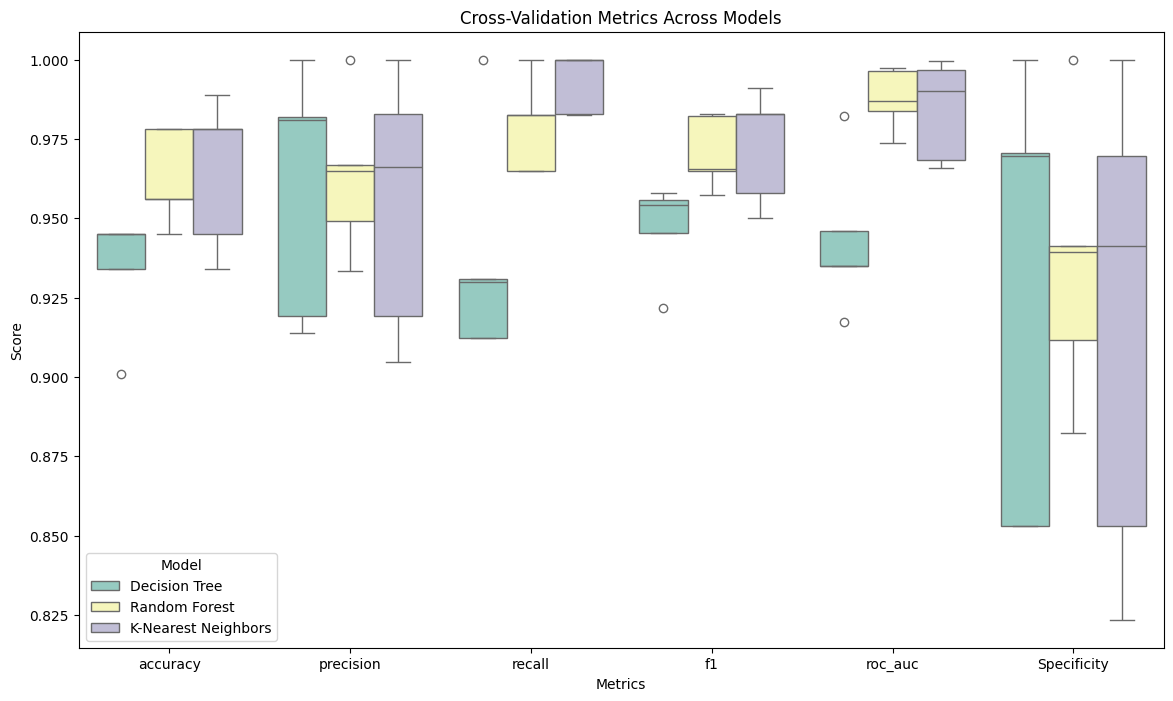

In [ ]:
#Perform 5-fold cross-validation with the following metrics:
#Accuracy, Precision, Recall, Specificity, F1-Score, Area Under the Curve
#Use boxplot to visualize the distribution of the metrics

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    return cm[0, 0] / (cm[0, 0] + cm[0, 1])

def cross_val_metrics(model, x, y, cv=5):
    scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = {metric: cross_val_score(model, x, y, cv=cv, scoring=metric) for metric in scoring_metrics}
    
    specificity_scores = cross_val_score(model, x, y, cv=cv, scoring=make_scorer(specificity_score))
    
    scores['Specificity'] = specificity_scores
    return scores


dt_scores = cross_val_metrics(dt_grid.best_estimator_, x_train, y_train)
rf_scores = cross_val_metrics(rf_grid.best_estimator_, x_train, y_train)
knn_scores = cross_val_metrics(knn_grid.best_estimator_, x_train, y_train)

dt_df = pd.DataFrame(dt_scores)
dt_df['Model'] = 'Decision Tree'
rf_df = pd.DataFrame(rf_scores)
rf_df['Model'] = 'Random Forest'
knn_df = pd.DataFrame(knn_scores)
knn_df['Model'] = 'K-Nearest Neighbors'

metrics_df = pd.concat([dt_df, rf_df, knn_df])

plt.figure(figsize=(14, 8))
sns.boxplot(x='variable', y='value', hue='Model', data=pd.melt(metrics_df, id_vars=['Model']), palette="Set3")
plt.xlabel("Metrics")
plt.ylabel("Score")
plt.title("Cross-Validation Metrics Across Models")
plt.legend(title="Model")
plt.show()